<a href="https://colab.research.google.com/github/lee-thien-tuyen/PCB_faults_extract/blob/main/train_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Train_PCB_faults/PCBData.rar" "/content/drive/MyDrive/Train_PCB_faults/"

In [2]:
import os
import cv2
import os
import glob

CLASSES = [
    "open", "short", "mousebit",
    "spur", "copper", "pin-hole"
]

DATASET_PATH = "/content/drive/MyDrive/Train_PCB_faults/PCBData"
OUTPUT_PATH = "/content/drive/MyDrive/Train_PCB_faults/output"
DEFECTS_PATH = os.path.sep.join([DATASET_PATH, "defects"])
TEST_PATH = os.path.sep.join([DATASET_PATH, "test_defects"])

In [ ]:
os.makedirs(DEFECTS_PATH, exist_ok=True)
for catigorie in CLASSES:
    os.makedirs(os.path.sep.join([DEFECTS_PATH, catigorie]), exist_ok=True)

for group in os.listdir(DATASET_PATH):
    if group.startswith('group'):
        print(f"[INFO] Extracted defects from {group}")
        group_images_path = os.path.sep.join([DATASET_PATH, group, group[5:]])
        group_annotations_path = f"{group_images_path}_not"
        for annotation in os.listdir(group_annotations_path):
            image = cv2.imread(os.path.sep.join([group_images_path, f"{annotation[:-4]}_test.jpg"]))
            with open(os.path.sep.join([group_annotations_path, annotation]), 'r') as f:
                defects_data = f.read()
                for i, line in enumerate(defects_data.splitlines()):
                    (x1, y1, x2, y2, c) = map(lambda t: int(t), line.split(' '))
                    label = CLASSES[c-1]
                    region = image[y1:y2, x1:x2]
                    cv2.imwrite(os.path.sep.join([DEFECTS_PATH, label, f"defect_{annotation[:-4]}_{i}.jpg"]), region)

In [3]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [4]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [5]:
trainGen = datagenAug.flow_from_directory(
    DEFECTS_PATH, classes=CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    DEFECTS_PATH, classes=CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [6]:
resnet_model = ResNet101(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

head = resnet_model.output
head = AveragePooling2D(pool_size=(7, 7))(head)
flatten = Flatten()(head)
fc = Dense(512, activation = "relu")(flatten)
fc = Dropout(0.5)(fc)
output = Dense(len(trainGen.class_indices), activation = "softmax")(fc)

model = Model(inputs=resnet_model.input, outputs=output)

171446536/171446536 [==============================] - 9s 0us/step


In [7]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
checkpoint = ModelCheckpoint(os.path.sep.join([OUTPUT_PATH, "resnet101.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [9]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=5, callbacks=[checkpoint, early])

model.save(os.path.sep.join([OUTPUT_PATH, "resnet101.model"]), save_format='h5')

Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.15625, saving model to /content/drive/MyDrive/Train_PCB_faults/output/resnet101.h5
  1/250 [..............................] - ETA: 3:24:02 - loss: 2.9014 - accuracy: 0.1562
Epoch 1: accuracy improved from 0.15625 to 0.17188, saving model to /content/drive/MyDrive/Train_PCB_faults/output/resnet101.h5
  2/250 [..............................] - ETA: 2:13:53 - loss: 2.5416 - accuracy: 0.1719
Epoch 1: accuracy improved from 0.17188 to 0.17708, saving model to /content/drive/MyDrive/Train_PCB_faults/output/resnet101.h5
  3/250 [..............................] - ETA: 2:01:54 - loss: 2.4600 - accuracy: 0.1771
Epoch 1: accuracy improved from 0.17708 to 0.17969, saving model to /content/drive/MyDrive/Train_PCB_faults/output/resnet101.h5
  4/250 [..............................] - ETA: 2:02:04 - loss: 2.6064 - accuracy: 0.1797
Epoch 1: accuracy improved from 0.17969 to 0.18750, saving model to /content/drive/MyDrive/Train_PCB_faults/output/resne

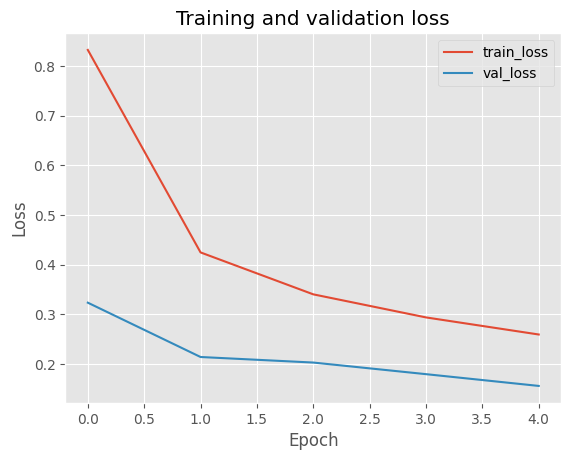

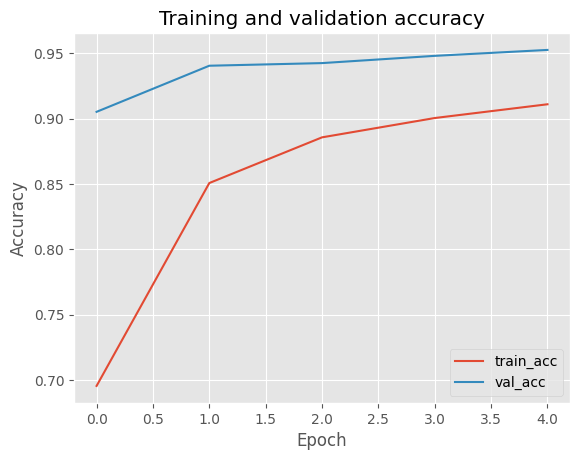

In [11]:
N = np.arange(0, 5)
plt.style.use("ggplot")

plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.sep.join([OUTPUT_PATH, "resnet_losses.png"]))

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.sep.join([OUTPUT_PATH, "resnet_accuracy.png"]))

plt.show()

In [12]:
from tensorflow.keras.models import load_model
model = load_model(os.path.sep.join([OUTPUT_PATH, "resnet101.model"]))

1/1 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

        open      0.808     0.974     0.883       388
       short      0.822     0.967     0.889       301
    mousebit      0.910     0.697     0.790       393
        spur      0.948     0.778     0.855       325
      copper      0.993     0.925     0.958       294
    pin-hole      0.884     0.993     0.936       300

    accuracy                          0.883      2001
   macro avg      0.894     0.889     0.885      2001
weighted avg      0.891     0.883     0.880      2001



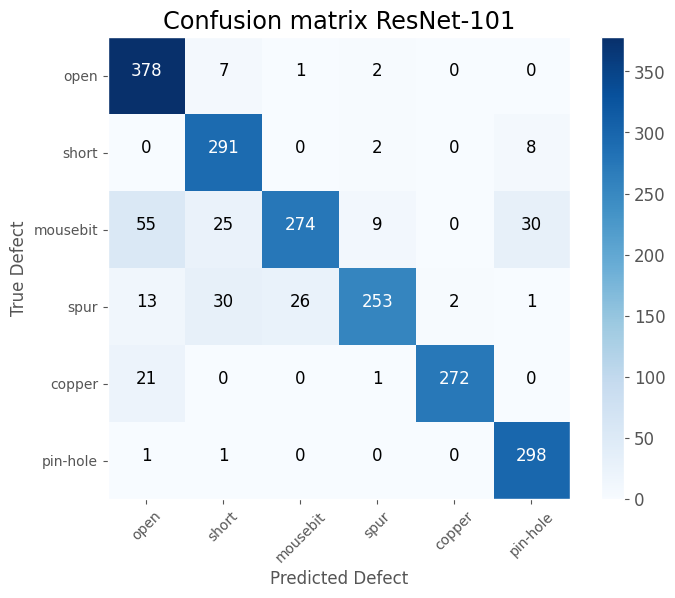

In [14]:
import itertools

predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices, digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix ResNet-101')
plt.savefig(OUTPUT_PATH + '/resnet_confusion_matrix.png')
plt.show()

In [ ]:
# %cd /content/drive/MyDrive/Train_PCB_faults/
# model_json =model.to_json()
# with open("model_resnet101.json","w") as json_file:
#   json_file.write(model_json)